In [351]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [197]:
import random
from collections import defaultdict, Counter

In [198]:
def get_synthetic_data(sigma=1):
    means = [np.array([-1, -1]), np.array([1, -1]), np.array([0, 1])]
    var = [np.array([[2, 0.5], [0.5, 1]]), 
           np.array([[1, -0.5], [-0.5, 2]]), 
           np.array([[1, 0], [0, 2]])]
    
    data = []
    for ind in range(len(means)):
        data.append(np.random.multivariate_normal(means[ind], sigma*var[ind], 100))
    
    return np.array(data)
        
    

In [199]:
syn_data = get_synthetic_data()

In [200]:
np.mean(syn_data[0], axis=0)

array([-1.00644307, -0.87499536])

In [201]:
syn_data_shape = syn_data.shape
data = np.reshape(syn_data, (syn_data_shape[0]*syn_data_shape[1], syn_data_shape[-1]))

In [202]:
data.shape

(300, 2)

In [203]:
initial_cluster_vals = np.random.choice(np.arange(len(data)), 3)

In [204]:
cluster_means_init = {'1': data[initial_cluster_vals[0]],
                 '2': data[initial_cluster_vals[1]],
                 '3': data[initial_cluster_vals[2]]}

In [205]:
def sum_distances(data_point, cluster_means):
    return np.sum([np.sum((data_point-v)**2) for k,v in cluster_means.items()])

In [206]:
def cluster_init(data, kmeanspp=False):
    cluster_means_init = defaultdict(list)
    if not kmeanspp:
        initial_cluster_vals = np.random.choice(np.arange(len(data)), 3)
        cluster_means_init = {'1': data[initial_cluster_vals[0]],
                    '2': data[initial_cluster_vals[1]],
                    '3': data[initial_cluster_vals[2]]}
    else:
        initial_cluster_vals = np.random.choice(np.arange(len(data)), 1)
        cluster_means_init['1'] = data[initial_cluster_vals[0]]
        
        ## TODO: have to add probability based sampling method
        for itr in [2,3]:
            distances = [(id, sum_distances(data[id], cluster_means_init)) 
                         for id in range(len(data))]
            sorted_dist_id = sorted(distances, key= lambda x: x[1], reverse=True)[0][0]
            cluster_means_init[str(itr)] = data[sorted_dist_id]
            
    
    return cluster_means_init

In [207]:
cluster_means_init = cluster_init(data, kmeanspp=True)
cluster_means_init

defaultdict(list,
            {'1': array([-0.84749082, -0.64811644]),
             '2': array([4.21997331, 1.26975959]),
             '3': array([-4.68170076, -0.70541497])})

In [208]:
def find_closest(data, cluster_means):
    distances = [(k, np.sum((data-v)**2)) for k,v in cluster_means.items()]
    sorted_dist = sorted(distances, key= lambda x: x[1])
    # print(sorted_dist)
    return sorted_dist[0][0]
        

In [209]:
def k_means_itr(data, cluster_means):
    clusters = defaultdict(list)
    for data_point in data:
        cluster_id = find_closest(data_point, cluster_means)
        clusters[cluster_id].append(data_point)
    # print(clusters)
    updated_cluster_means = defaultdict(list)
    # updated_cluster_means = cluster_means
    for k,v in clusters.items():
        updated_cluster_means[k] = np.mean(np.array(v), axis=0)
    # print(updated_cluster_means)
    return clusters, updated_cluster_means

In [210]:
def check_termination(new_means, means):
    distance = np.sum([np.sum((v-u)**2) for v,u in zip(new_means.values(), means.values())])
    
    return distance

In [211]:
def kmeans(data, cluster_means):
    clusters, updated_cluster_means = k_means_itr(data, cluster_means)
    while(check_termination(updated_cluster_means, cluster_means) > 1e-4):
        cluster_means = updated_cluster_means
        clusters, updated_cluster_means = k_means_itr(data, cluster_means)
    
    return clusters, updated_cluster_means

In [212]:
res = kmeans(data, cluster_means_init)

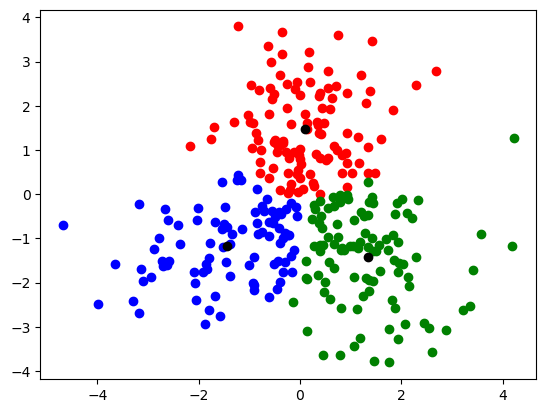

In [214]:
colors = {'1':'g', '2': 'r', '3':'b'}
for k,v in res[0].items():
    v = np.array(v)
    plt.scatter(v[:,0], v[:,1], c=colors[k])
    mean = np.mean(v, axis=0)
    plt.scatter(mean[0], mean[1], c='black')

plt.show()

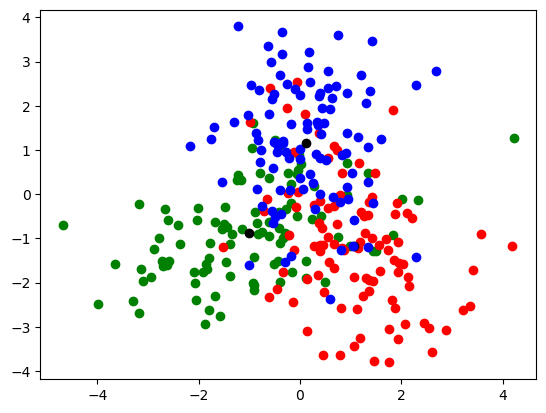

In [215]:
colors = {'1':'g', '2': 'r', '3':'b'}
for itr in range(3):
    v = np.array(syn_data[itr])
    plt.scatter(v[:,0], v[:,1], c=colors[str(itr+1)])
    mean = np.mean(v, axis=0)
    plt.scatter(mean[0], mean[1], c='black')

plt.show()

In [216]:
def clustering_objective(clusters, means):
    objective = 0
    for k,v in clusters.items():
        objective += np.sum([np.sum((x-means[k])**2) for x in v])
    return objective

In [217]:
clustering_objective(res[0], res[1])

513.0231956490777

In [218]:
def clustering_accuracy(syn_data, means):
    clusters = defaultdict(list)
    for itr in range(3):
        for data_point in syn_data[itr]:
            cluster_id = find_closest(data_point, means)
            clusters[itr].append(cluster_id)
    cluster_matching = defaultdict(str)
    
    total = 0
    correct = 0
    for k,v in clusters.items():
        counts = Counter(v)
        cluster_matching[k] = sorted(counts.items(), key= lambda x: x[1], 
                                     reverse=True)[0][0]
    
        total += sum(counts.values())
        correct += counts[cluster_matching[k]]
        
        
    return correct/total

In [219]:
clustering_accuracy(syn_data, res[1])

0.7433333333333333

In [897]:
sigma_vals = [0.5, 1, 2, 4, 8]
c_objective_km = []
c_accuracy_km = []

for sigma in sigma_vals:
    syn_data = get_synthetic_data(sigma=sigma)
    syn_data_shape = syn_data.shape
    data = np.reshape(syn_data, (syn_data_shape[0]*syn_data_shape[1], syn_data_shape[-1])) 
    cluster_means_init = cluster_init(data, kmeanspp=True)
    res = kmeans(data, cluster_means_init)
    c_objective_km.append(clustering_objective(res[0], res[1]))
    c_accuracy_km.append(clustering_accuracy(syn_data, res[1]))
    
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


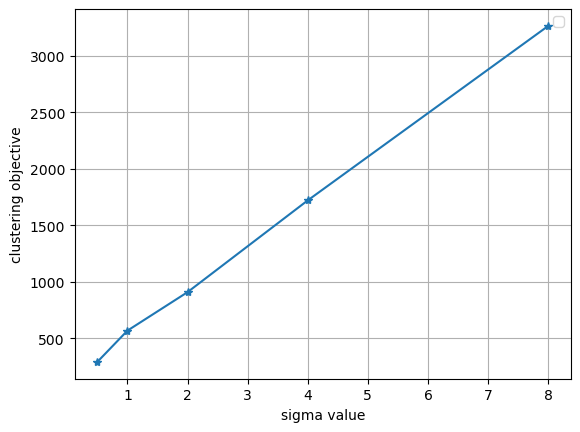

In [898]:
plt.plot(sigma_vals, c_objective_km, marker='*')
plt.xlabel("sigma value")
plt.ylabel("clustering objective")
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


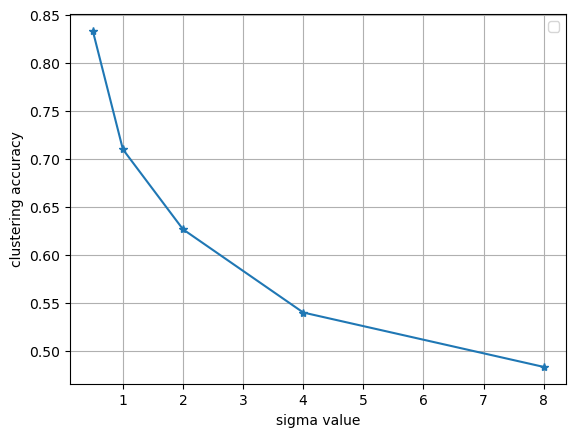

In [899]:
plt.plot(sigma_vals, c_accuracy_km, marker='*')
plt.xlabel("sigma value")
plt.ylabel("clustering accuracy")
plt.legend()
plt.grid()
plt.show()

In [259]:
from scipy.stats import multivariate_normal

In [807]:
syn_data = get_synthetic_data(sigma=sigma)
syn_data_shape = syn_data.shape
data = np.reshape(syn_data, (syn_data_shape[0]*syn_data_shape[1], syn_data_shape[-1])) 
data.shape

(300, 2)

In [882]:
def multivariate_normal_pdf(x, mean, cov):
    # print(mean, cov)
    if np.linalg.det(cov) == 0:
        return 0
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    
    mat_x = (-0.5)*((x-mean).T@(inv_cov@(x-mean)))
    # print(f'matrix_val {mat_x}')
    val = np.exp(mat_x)
    
    return (1/((2*np.pi)*np.sqrt(det_cov)))*val

In [883]:
def sample_prob_to_cluster(x, means, vars, priors):
    vals = []
    for i in range(3):
    # vals = [pr*multivariate_normal(x, mu, cov) for mu, cov,pr in zip(means, vars, priors)]
        val = multivariate_normal_pdf(x, means[i], vars[i])
        vals.append(priors[i]*val)
    ## weights; r_ic
    w = vals/(sum(vals)+1e-8)
    return w

In [884]:
def get_update_params(data, means, vars, priors=[1/3,1/3,1/3]):
    weights = []
    for data_point in data:
        weights.append(sample_prob_to_cluster(data_point, means, vars, priors))
    
    ## r_ic
    weights = np.array(weights)
    # print(weights)
    # m_c = sum_i r_ic
    m_c = [sum(weights[:,c]) for c in range(len(weights[0]))]
    
    # print(weights)
    #pi_c = m_c / sum_c m_c
    updated_priors = m_c/sum(m_c)
    
    # print(m_c)
    # print(updated_priors)
    # mu_c = (1/m_c) *(sum_i r_ic * x_i)
    updated_means = []
    for c in range(len(weights[0])):
        val_mean = 0
        for i in range(len(data)):
            val_mean += (weights[i,c]) * data[i]
        updated_means.append(val_mean/m_c[c])
    
    updated_vars = []  
    for c in range(len(weights[0])):
        val_vars = np.zeros((2,2))
        for i in range(len(data)):
            val_vars += (weights[i,c]) * np.matmul((data[i]-updated_means[c]),
                                                   (data[i]-updated_means[c]).T)
            
        updated_vars.append(val_vars/m_c[c])
    
    # print(updated_means, updated_vars)
    return updated_priors, updated_means, updated_vars

In [885]:
def log_likelihood_cost(data, means, vars, priors=[1/3,1/3,1/3]):
    cost = 0
    for i in range(len(data)):
        val = sum([pr*multivariate_normal_pdf(data[i], mu, cov)
                   for mu, cov, pr in zip(means, vars, priors)])
        if val != 0:
            cost += -np.log(val)
    # print(cost)
    return cost

In [886]:
def GMM_clustering(data, means, vars):
    updated_priors, updated_means, updated_vars = get_update_params(data, means, vars)
    
    initial_cost = log_likelihood_cost(data, means, vars)
    updated_cost = log_likelihood_cost(data, updated_means, updated_vars, updated_priors)
    # print(means, vars)
    # print(updated_means, updated_vars)
    print(initial_cost, updated_cost)
    while abs(updated_cost) >1e-5:
        means, vars, priors = updated_means, updated_vars, updated_priors
        updated_priors, updated_means, updated_vars = get_update_params(data, means, vars, priors)
        # print(updated_means, updated_vars)
        initial_cost = log_likelihood_cost(data, means, vars, priors)
        updated_cost = log_likelihood_cost(data, updated_means, updated_vars, updated_priors)
        print(initial_cost, updated_cost)
    return updated_priors, updated_means, updated_vars
        

In [887]:
means =data[np.random.choice(len(data), 3)]
vars = [np.cov(np.transpose(data))]*3

In [888]:
res_GMM = GMM_clustering(data, means, vars)

1198.2701069272784 0


In [889]:
res_GMM[0]

array([0.43837914, 0.31491839, 0.24670247])

In [890]:
res_GMM[1]

[array([0.38987382, 0.83439248]),
 array([-0.70851587, -0.7692453 ]),
 array([-0.1412524 , -1.43633561])]

In [904]:
sigma_vals = [0.5, 1, 2, 4, 8]
c_objective = []
c_accuracy = []

for sigma in sigma_vals:
    syn_data = get_synthetic_data(sigma=sigma)
    syn_data_shape = syn_data.shape
    data = np.reshape(syn_data, (syn_data_shape[0]*syn_data_shape[1], syn_data_shape[-1])) 
    means =data[np.random.choice(len(data), 3)]
    vars = [np.cov(np.transpose(data))]*3   
    res_GMM = GMM_clustering(data, means, vars)
    c_accuracy.append(clustering_accuracy(syn_data, res[1]))
    

1070.0775846397644 0
1268.5326837642322 0
1411.6003940476362 0
1499.2372693440848 0
1743.1673886076921 0


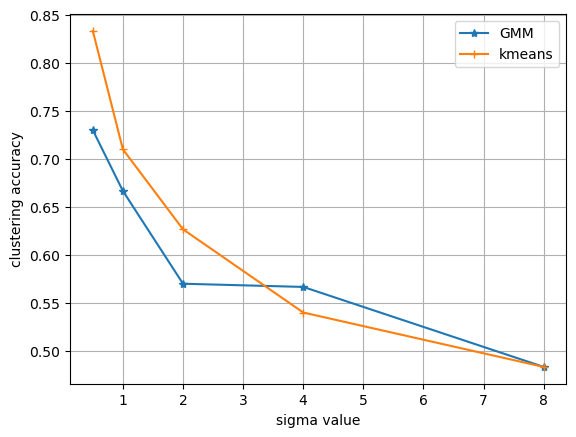

In [911]:
plt.plot(sigma_vals, c_accuracy, marker='*', label='GMM')
plt.plot(sigma_vals, c_accuracy_km, marker='+', label='kmeans')
plt.xlabel("sigma value")
plt.ylabel("clustering accuracy")
plt.legend()
plt.grid()
# plt.show()
plt.savefig("clustering_accuracy.pdf")

In [906]:
c_objective = [1070.0775846397644,
1268.5326837642322,
1411.6003940476362,
1499.2372693440848,
1743.1673886076921]

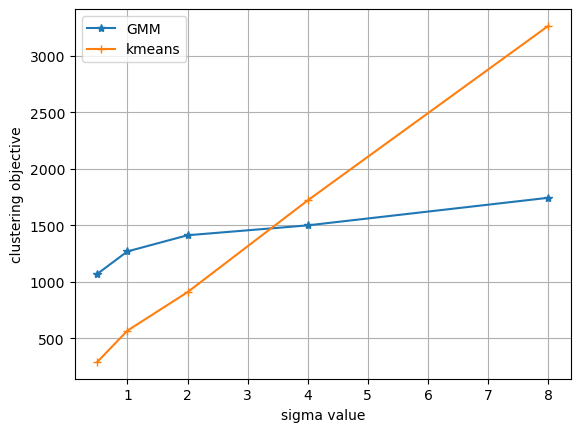

In [912]:
plt.plot(sigma_vals, c_objective, marker='*', label='GMM')
plt.plot(sigma_vals, c_objective_km, marker='+', label='kmeans')
plt.xlabel("sigma value")
plt.ylabel("clustering objective")
plt.legend()
plt.grid()
# plt.show()
plt.savefig('clustering_objective.pdf')